# Bird Call Identification

This colab file is about a audio processing and deep learning problem which classify the species of bird given its audio call. This task include processing the audio, creating spectrograms, creating a CNN and some complex models, comparing accuracy of several models.

Data Source: Kaggle

If working with google colab data can be fetched like this way

### Fetching the zipped file of dataset from kaggle using API

In [1]:
# # These are the commands to connect with kaggle API and hence, fetch any data from kaggle using the API of that data

# ! mkdir  ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [2]:
# ! pip install kaggle            ## Uncomment if kaggle not installed

In [3]:
# Downloading the zipped file of dataset

# !kaggle datasets download -d gauravduttakiit/sa-bird-call-audio-identification-challenge

In [4]:
# Unzip the dataset

# !unzip sa-bird-call-audio-identification-challenge

Fetching data while working in kaggle notebook

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sa-bird-call-audio-identification-challenge/submission.csv
/kaggle/input/sa-bird-call-audio-identification-challenge/sol/CMHURP.mp3
/kaggle/input/sa-bird-call-audio-identification-challenge/sol/P3A2N8.mp3
/kaggle/input/sa-bird-call-audio-identification-challenge/sol/1ME9HD.mp3
/kaggle/input/sa-bird-call-audio-identification-challenge/sol/KQOF1W.mp3
/kaggle/input/sa-bird-call-audio-identification-challenge/sol/QSKKPD.mp3
/kaggle/input/sa-bird-call-audio-identification-challenge/sol/CIQIC9.mp3
/kaggle/input/sa-bird-call-audio-identification-challenge/sol/EYXOS6.mp3
/kaggle/input/sa-bird-call-audio-identification-challenge/sol/CF622O.mp3
/kaggle/input/sa-bird-call-audio-identification-challenge/sol/6RB2JS.mp3
/kaggle/input/sa-bird-call-audio-identification-challenge/sol/1NTV3G.mp3
/kaggle/input/sa-bird-call-audio-identification-challenge/sol/Q36S9N.mp3
/kaggle/input/sa-bird-call-audio-identification-challenge/sol/O1W9G0.mp3
/kaggle/input/sa-bird-call-audio-identification-cha

## Converting the zipped file data to dataframes

The data is in the form of audio files. These audio files are further existing in a directory. We are converting these folder of audio files to a labeled dataframe.

In [6]:
import os

train_dir = '/kaggle/input/sa-bird-call-audio-identification-challenge/train/'
test_dir = '/kaggle/input/sa-bird-call-audio-identification-challenge/test/'

data_folders = [os.path.join(train_dir, f) for f in os.listdir(train_dir)]

# print(len(data_folders))                         ## It include bird call of 40 different species
print(data_folders)

['/kaggle/input/sa-bird-call-audio-identification-challenge/train/Black Cuckoo', '/kaggle/input/sa-bird-call-audio-identification-challenge/train/Green-backed Camaroptera', '/kaggle/input/sa-bird-call-audio-identification-challenge/train/Tawny-flanked Prinia', '/kaggle/input/sa-bird-call-audio-identification-challenge/train/Olive Bushshrike', '/kaggle/input/sa-bird-call-audio-identification-challenge/train/Dark-capped Bulbul', '/kaggle/input/sa-bird-call-audio-identification-challenge/train/Long-billed Crombec', '/kaggle/input/sa-bird-call-audio-identification-challenge/train/African Paradise Flycatcher', '/kaggle/input/sa-bird-call-audio-identification-challenge/train/Crested Barbet', '/kaggle/input/sa-bird-call-audio-identification-challenge/train/African Pipit', '/kaggle/input/sa-bird-call-audio-identification-challenge/train/Green Wood Hoopoe', '/kaggle/input/sa-bird-call-audio-identification-challenge/train/Ring-necked Dove', '/kaggle/input/sa-bird-call-audio-identification-challe

In [7]:
# paths list contain the path to each audio file

data_paths = []

for i in data_folders:
  path = [os.path.join(i, f) for f in os.listdir(i)]
  data_paths.extend(path)

In [8]:
print("Data for training:", len(data_paths))
print("Random data:", data_paths[16])

Data for training: 1485
Random data: /kaggle/input/sa-bird-call-audio-identification-challenge/train/Black Cuckoo/Y78YUH.mp3


In [9]:
# Playing audio file

from IPython.display import Audio

Audio(data_paths[1090], autoplay=True)

###Importing files

In [10]:
import librosa as lr
import librosa.display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal

from PIL import Image

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

### Creating Dataframe

In [11]:
train_paths = pd.DataFrame()
train_paths['file'] = data_paths
train_paths['bird'] = [file_name.split('/')[3] for file_name in data_paths]

print(train_paths.shape)
train_paths.head()

(1485, 2)


,file,bird
0,/kaggle/input/sa-bird-call-audio-identificatio...,sa-bird-call-audio-identification-challenge
1,/kaggle/input/sa-bird-call-audio-identificatio...,sa-bird-call-audio-identification-challenge
2,/kaggle/input/sa-bird-call-audio-identificatio...,sa-bird-call-audio-identification-challenge
3,/kaggle/input/sa-bird-call-audio-identificatio...,sa-bird-call-audio-identification-challenge
4,/kaggle/input/sa-bird-call-audio-identificatio...,sa-bird-call-audio-identification-challenge


##Data Preprocessing

1. Clean the audio file
2. Convert the audio file to spectrogram
3. Save spectrogram image

### Clean Audio

In [12]:
# BEFORE CLEANING AUDIO

audio, freq_sec = lr.load(data_paths[2])
Audio(audio, rate = freq_sec, autoplay = True)

In [13]:
# AFTER CLEANING AUDIO

b, a = signal.butter(10, 2000/(freq_sec/2), btype='highpass')    #  A type of signal processing filter designed to have a frequency response as flat as possible in the pass band.
cleaned = signal.lfilter(b,a, audio)
Audio(cleaned, rate = freq_sec, autoplay = True)

###Plotting STFT i.e. Short Time Fourier Transform and Mel spectrogram.

/tmp/ipykernel_19/2735940554.py:4: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  sig_db = librosa.amplitude_to_db(sig)


Text(0.5, 1.0, 'Mel Spectrogram')

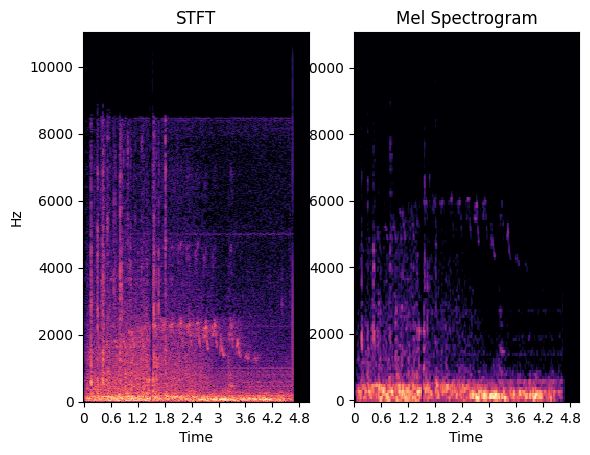

In [14]:
fig, ax = plt.subplots(1, 2)

sig = librosa.stft(audio)
sig_db = librosa.amplitude_to_db(sig)
librosa.display.specshow(sig_db, sr = freq_sec, ax = ax[0], x_axis='time', y_axis='hz', cmap = 'magma')
ax[0].set_title('STFT')

sig = librosa.feature.melspectrogram(y=audio)
sig_db = librosa.amplitude_to_db(abs(sig))
librosa.display.specshow(sig_db, sr = freq_sec, ax = ax[1], x_axis='time', y_axis='hz', cmap = 'magma')
plt.title('Mel Spectrogram')

Text(0.5, 1.0, 'Cleaned Mel Spectrogram')

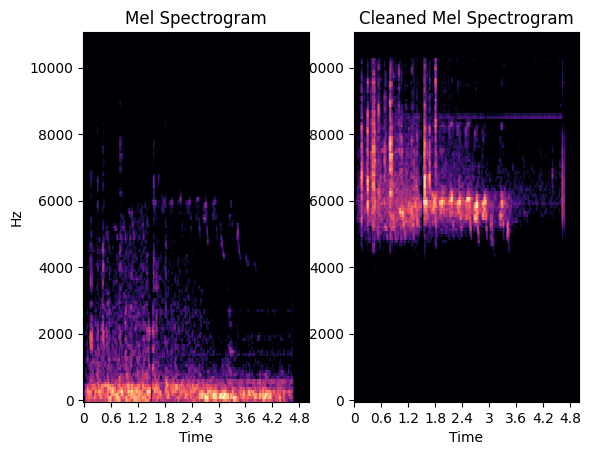

In [15]:
# AFTER Cleaning Mel Spectrogram
fig, ax = plt.subplots(1, 2)

sig = librosa.feature.melspectrogram(y=audio)
sig_db = librosa.amplitude_to_db(abs(sig))
librosa.display.specshow(sig_db, sr = freq_sec, ax = ax[0], x_axis='time', y_axis='hz', cmap = 'magma')
ax[0].set_title('Mel Spectrogram')

sig = librosa.feature.melspectrogram(y = cleaned)
sig_db = librosa.amplitude_to_db(abs(sig))
librosa.display.specshow(sig_db, sr = freq_sec, ax = ax[1], x_axis='time', y_axis='hz', cmap = 'magma')
plt.title('Cleaned Mel Spectrogram')

In above figure you won't be able to see any difference because the audio file hadn't had much of noise resulting in nearly similar spectrograms a part from few minor changes in very last few seconds.

###Saving spectrogram

In [16]:
def clean_and_spect(dire , path):
    audio, freq_sec = lr.load(path)
    b, a = signal.butter(10, 2000/(freq_sec/2), btype='highpass')
    cleaned = signal.lfilter(b, a, audio)
    sig = librosa.feature.melspectrogram(y = cleaned)
    sig_db = librosa.amplitude_to_db(abs(sig)[:,:min(1025, len(sig[0]))])

    librosa.display.specshow(sig_db, sr = freq_sec, x_axis='time', y_axis='hz', cmap = 'cividis')
    plt.savefig(dire + path.split('/')[-1][:-3]+'png')
    plt.clf()

In [17]:
# Delete folder from directory
# import shutil
# shutil.rmtree("/kaggle/working/train")

In [18]:
image_train = []

os.mkdir('train')
dire_list = []
for i in range(len(train_paths)):
    paths = train_paths['file'][i]

    if paths.split('/')[5] not in dire_list:
        os.mkdir('/kaggle/working/train/'+ paths.split('/')[5])
        dire_list.append(paths.split('/')[5])
        
    dire = '/kaggle/working/train/' + dire_list[-1] + '/'
    clean_and_spect(dire, paths)

    image_train.append(dire + paths.split('/')[-1][:-3]+'png')

<Figure size 640x480 with 0 Axes>

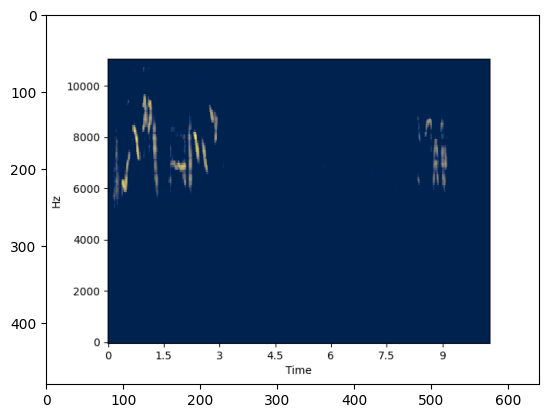

In [19]:
image = Image.open('/kaggle/working/train/Sabota Lark/RS81B1.png')
plt.imshow(image)

###Checking the shape of all images

As the images fed into the convolutional neural network should have same data type and same size. Ex, (256, 256), (512, 512)

In [20]:
all_unit8 = True
all_pixel_in_range = True

for i in range(len(image_train)):
  loc = image_train[i]
  with Image.open(loc) as img:
    img_arr = np.array(img)

    if img_arr.dtype != 'uint8':
      all_unit8 = False

    if img_arr.min() < 0 and img_arr.max() > 255:
      all_pixel_in_range = False

if all_unit8 == True:
  print("All images have same data type")
else:
  print("All images don't have same data type")

if all_pixel_in_range == True:
  print("All pixels in range")
else:
  print("All pixels not in range")

All images have same data type
All pixels in range


###Splitting data in training and validation

The data is split into 8:2 ratio which means 80% of the training dataset and 20% of validation dataset.

In [21]:
train = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/working/train',
    label_mode = 'categorical',
    image_size = (256, 256),
    shuffle = True,
    seed =  80,
    batch_size = 16,
    validation_split = .20,
    subset = 'training',
    crop_to_aspect_ratio = True
)

valid = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/working/train',
    label_mode = 'categorical',
    image_size = (256, 256),
    shuffle = True,
    seed =  80,
    batch_size = 16,
    validation_split = .20,
    subset = 'validation',
    crop_to_aspect_ratio = True
)

Found 1485 files belonging to 40 classes.
Using 1188 files for training.
Found 1485 files belonging to 40 classes.
Using 297 files for validation.


###Rescaling image

Image pixels varry from 0 to 255. These pixels are rescaled to the range of 0 to 1.

In [22]:
scaler = tf.keras.layers.Rescaling(1./255)

train = train.map(lambda x, y: (scaler(x), y))
valid = valid.map(lambda x, y: (scaler(x), y))

##Convolutional Neural Network

In [23]:
from tensorflow.keras import regularizers

In [24]:
# Images are resized to (256, 256) pixels
image_size = (256, 256)

# Define the model
model = models.Sequential()

# Convolutional and Pooling Layers
model.add(layers.Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=(image_size[0], image_size[1], 3)))
model.add(layers.MaxPooling2D((3, 3)))

model.add(layers.Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((3, 3)))

model.add(layers.Conv2D(128, (5, 5), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((3, 3)))

# Flatten the output for the dense layers
model.add(layers.Flatten())

# Dense Layers
model.add(layers.Dense(512, activity_regularizer=regularizers.L2(l2=1e-4), activation='relu'))#, activity_regularizer=regularizers.L2(l2=1e-4))   # kernel_regularizer=regularizers.L1(l1=1e-5),
model.add(layers.Dropout(0.8))
model.add(layers.Dense(40, activation='softmax'))  # Assuming 40 classes for classification

In [25]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss="categorical_crossentropy",  # Use 'categorical_crossentropy' if labels are one-hot encoded
              metrics=['accuracy'])

In [26]:
# early_stopping = EarlyStopping(monitor = 'val_accuracy',
#                                patience = 7,
#                                mode = 'max',
#                                restore_best_weights = True)

# model_checkpoint = ModelCheckpoint('/kaggle/working/best_model.h5',
#                                    monitor = 'val_accuracy',
#                                    save_best_only = True)

In [27]:
try:
    history = model.fit(train,
                        epochs = 20,
                        validation_data = valid)
#                         callbacks = [early_stopping, model_checkpoint])
except Exception as e:
  print("An error occurred: ",e)

Epoch 1/20
75/75 [==============================] - 60s 790ms/step - loss: 3.7430 - accuracy: 0.0547 - val_loss: 3.6718 - val_accuracy: 0.0471
Epoch 2/20
75/75 [==============================] - 60s 797ms/step - loss: 3.5829 - accuracy: 0.0614 - val_loss: 3.4099 - val_accuracy: 0.0572
Epoch 3/20
75/75 [==============================] - 60s 788ms/step - loss: 3.3539 - accuracy: 0.1170 - val_loss: 3.1234 - val_accuracy: 0.1313
Epoch 4/20
75/75 [==============================] - 59s 786ms/step - loss: 3.1359 - accuracy: 0.1633 - val_loss: 2.9767 - val_accuracy: 0.1717
Epoch 5/20
75/75 [==============================] - 60s 789ms/step - loss: 2.9514 - accuracy: 0.1919 - val_loss: 2.9086 - val_accuracy: 0.2424
Epoch 6/20
75/75 [==============================] - 60s 790ms/step - loss: 2.7772 - accuracy: 0.2382 - val_loss: 2.7619 - val_accuracy: 0.2525
Epoch 7/20
75/75 [==============================] - 60s 791ms/step - loss: 2.5975 - accuracy: 0.2828 - val_loss: 2.5850 - val_accuracy: 0.2828

In [28]:
# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 85, 85, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 28, 28, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       204928    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 9, 9, 128)         0

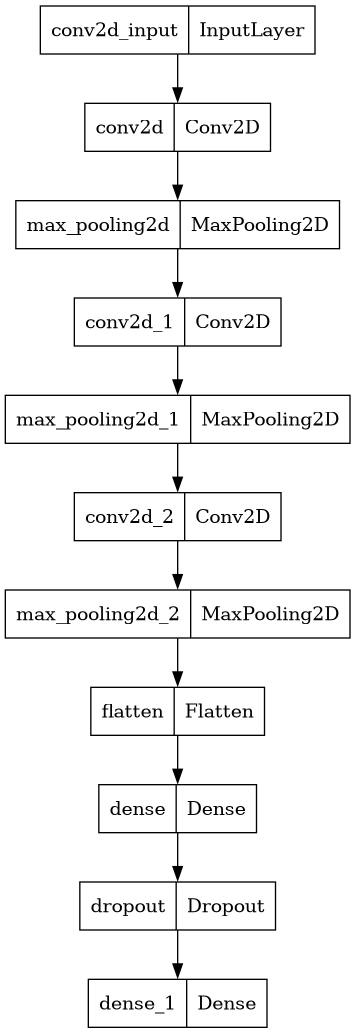

In [29]:
tf.keras.utils.plot_model(model)

##Plotting Results

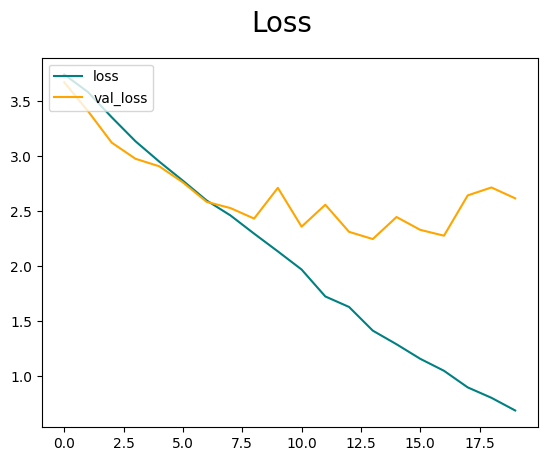

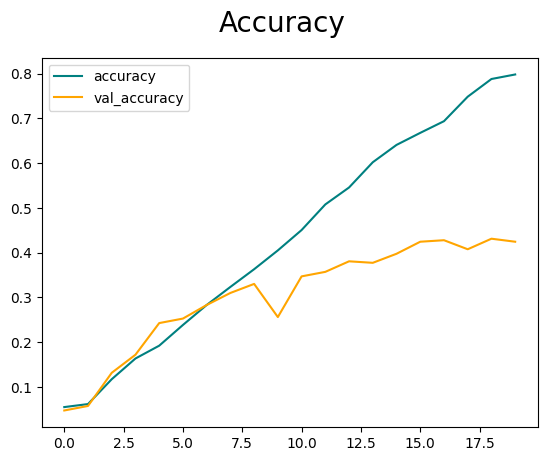

In [30]:
fig = plt.figure()

plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

##Preparing Test Data

In [31]:
test_folders = [os.path.join(test_dir, f) for f in os.listdir(test_dir)]

test_paths = []

for i in test_folders:
  path = [os.path.join(i, f) for f in os.listdir(i)]
  test_paths.extend(path)

print("Data for testing:", len(test_paths))
print("Random data:", test_paths[0])

test = pd.DataFrame()
test['file'] = test_paths
test['bird'] = [file_name.split('/')[5] for file_name in test_paths]

print(test.shape)
test.head()

Data for testing: 372
Random data: /kaggle/input/sa-bird-call-audio-identification-challenge/test/Black Cuckoo/YS949R.mp3
(372, 2)


,file,bird
0,/kaggle/input/sa-bird-call-audio-identificatio...,Black Cuckoo
1,/kaggle/input/sa-bird-call-audio-identificatio...,Black Cuckoo
2,/kaggle/input/sa-bird-call-audio-identificatio...,Black Cuckoo
3,/kaggle/input/sa-bird-call-audio-identificatio...,Black Cuckoo
4,/kaggle/input/sa-bird-call-audio-identificatio...,Black Cuckoo


##Pre-processing Test Data

In [32]:
# Cleaning audio and creating spectrogram
dire_list = []
os.mkdir('test')

for i in range(len(test)):
    paths = test['file'][i]

    if paths.split('/')[5] not in dire_list:
        os.mkdir('/kaggle/working/test/'+paths.split('/')[5])
        dire_list.append(paths.split('/')[5])
        
    dire = '/kaggle/working/test/' + dire_list[-1] + '/'
    clean_and_spect(dire, paths)

# Resizing images
test = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/working/test',
    label_mode = 'categorical',
    image_size = (256, 256),
    shuffle = True,
    seed =  110,
    batch_size = 32,
    validation_split = 0,
    crop_to_aspect_ratio = True
)

# Rescaling images
test = test.map(lambda x, y: (scaler(x), y))

Found 372 files belonging to 40 classes.


<Figure size 640x480 with 0 Axes>

##Performance Evaluation

In [33]:
# model.load_weights('/kaggle/working/best_model.h5')

pred = model.predict(test)
val_loss, val_acc = model.evaluate(test)

print('\nValidation Loss: ', val_loss)
print('\nValidation Accuracy: ', np.round(val_acc*100), '%')

12/12 [==============================] - 6s 412ms/step - loss: 2.4310 - accuracy: 0.5161

Validation Loss:  2.4310426712036133

Validation Accuracy:  52.0 %
